Name: Yuan Chen
ID: 9082757429

In [62]:
import torch
import torch.nn as nn
import torch.optim as opt
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [63]:
batch_size=64
EPOCHS=200
hidden_neurons=300
# device=torch.device('cuda')

In [64]:
train = datasets.MNIST("", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
test = datasets.MNIST("", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

#due to the long training time, this homework only use 10k training data points and 2000 testing datapoints
train2, _ = torch.utils.data.random_split(train, [10000, len(train)-10000])
test2, _ = torch.utils.data.random_split(test, [2000, len(test)-2000])

In [65]:
trainset = DataLoader(train, batch_size=batch_size, shuffle=True)
testset = DataLoader(test, batch_size=batch_size, shuffle=True)

trainset2 = DataLoader(train2, batch_size=batch_size, shuffle=True)
testset2 = DataLoader(test2, batch_size=batch_size, shuffle=True)

In [68]:
def train_model(model, epochs):
    train_loss = []
    for epoch in range(epochs):
        loss_sum = 0
        for data in trainset2:
            X, y = data
            X = X.view(-1, 784)
            opt.zero_grad()
            y_pred = model(X)
            loss = criterion(y_pred, y)
            loss_sum += loss
            loss.backward()
            opt.step()
        loss_avg = loss_sum*batch_size/len(trainset.dataset)
        train_loss.append(loss_avg)
    return train_loss
    
def test_model(model):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in testset2:
            X_t, y_t = data
            X_t = X_t.view(-1, 784)
            y_t_pred = model(X_t)
            for idx, i in enumerate(y_t_pred):
                if torch.argmax(i) == y_t[idx]:
                    correct += 1
                total += 1
        acc = round(correct/total, 3)
        err = round(1 - acc, 4)
        print('accuracy: ', acc, '    error rate: ', err)
    
def plot_learning_curve(train_loss, epochs, title):
    epoch_axis = []
    for i in range(epochs):
        epoch_axis.append(i)
    
    plt.plot(epoch_axis, train_loss)
    plt.title(title)
    plt.xlabel('epoch')
    plt.ylabel('loss')

In [45]:
#2 custom implementation of backpropagation
class myNN():
    def __init__(self, w1, w2):
        self.w1 = w1
        self.w2 = w2
        self.z1 = None
        self.z2 = None
        self.a1 = None
        self.a2 = None
        
    def forward(self, x):
        self.z1 = torch.mm(self.w1, torch.t(x))
        self.a1 = self.sigmoid(self.z1)
        self.z2 = torch.mm(self.w2, self.a1)
        self.a2 = torch.t(torch.softmax(self.z2, 0))
        return self.a2
    
    def sigmoid(self, z):
        #stable sigmoid
        s = torch.where(z<0, torch.exp(z)/(1+torch.exp(z)), 1/(1+torch.exp(-z)))
        return s
        
    def softmax(self, z):
        exps = torch.exp(z - torch.max(z))
        return exps / torch.sum(exps)
    
    def get_loss(self, y, y_pred):
        y_1hot = F.one_hot(y, num_classes=10)
        loss = 0
        m = y.shape[0]
        loss = -torch.sum(y_1hot * torch.log(y_pred.clip(min=1e-8)))
        return loss

    def loss_grad(self, y, y_pred):
        n = 10
        y_1hot = F.one_hot(y, num_classes=n)
        return y_pred - y_1hot
    
    def sigmoid_grad(self, z):
        grad = self.sigmoid(z)*(1-self.sigmoid(z))
        return grad
    
    def backward(self, x, y, learning_rate):
        n = 10
        #get grads
        da2 = self.loss_grad(y, self.a2)
        dw2 = torch.mm(torch.t(da2), torch.t(self.a1))
        dchain1 = torch.mm(da2, self.w2)
        s = self.sigmoid_grad(self.z1)
        dchain2 = torch.t(dchain1)*s
        dw1 = torch.mm(dchain2, x)
        
        #update param
        self.w1 -= learning_rate * dw1
        self.w2 -= learning_rate * dw2

In [59]:
w1 = torch.rand(hidden_neurons, 784)/28
w2 = torch.rand(10, hidden_neurons)/28
lr = 0.01
# lr_decay = 0.9
# step_size = 10

#train
train_loss = []

my_model = myNN(w1, w2)
for epoch in range(EPOCHS):    
    for data in trainset2:
        loss_sum = 0
        X, y = data
        X = X.view(-1, 784)
        out = my_model.forward(X)
        loss = my_model.get_loss(y, out)
        my_model.backward(X, y, lr)
        loss_sum += loss
    loss_avg = loss_sum*batch_size/len(trainset2.dataset)
    train_loss.append(loss_avg)
#     lr *= lr_decay**np.floor(epoch/step_size)

In [60]:
#test
correct = 0
total = 0
for data in testset2:
    X_t, y_t = data
    X_t = X_t.view(-1, 784)
    y_t_pred = my_model.forward(X_t)
    for idx, i in enumerate(y_t_pred):
        if torch.argmax(i) == y_t[idx]:
            correct += 1
        total += 1
acc = round(correct/total, 3)
err = round(1 - acc, 4)
print('accuracy: ', acc, '    error rate: ', err)

accuracy:  0.959     error rate:  0.041


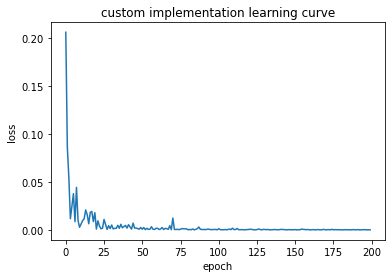

In [61]:
#plot
plot_learning_curve(train_loss, EPOCHS, 'custom implementation learning curve')

In [76]:
#3 pytorch framework training
class NN2(nn.Module):
    def __init__(self):
        super(NN2, self).__init__()
        self.fc1 = nn.Linear(784, hidden_neurons)
        self.fc2 = nn.Linear(hidden_neurons, 10)
        
    def forward(self, x):
        x = self.fc1(x)
        x = torch.sigmoid(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x

In [81]:
model = NN2()
opt = torch.optim.SGD(model.parameters(), lr=0.1)
criterion = torch.nn.CrossEntropyLoss()

In [82]:
train_loss = train_model(model, EPOCHS)

In [83]:
test_model(model)

accuracy:  0.833     error rate:  0.167


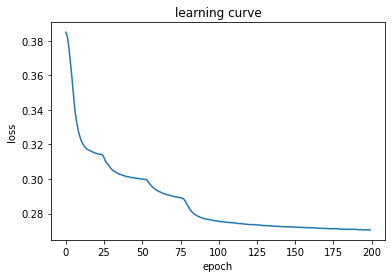

In [84]:
plot_learning_curve(train_loss, EPOCHS, 'learning curve')

In [ ]:
#4
#set w1 to all zero
all_zero_w1 = torch.zeros(hidden_neurons, 784)
#set w2 to all zero
all_zero_w2 = torch.zeros(10, hidden_neurons)

model.fc1.weight = nn.Parameter(all_zero_w1)
model.fc2.weight = nn.Parameter(all_zero_w2)

opt = torch.optim.SGD(model.parameters(), lr=0.1)
criterion = torch.nn.CrossEntropyLoss()

train_loss = train_model(model, 200)

In [203]:
test_model(model)

accuracy:  0.911     error rate:  0.089


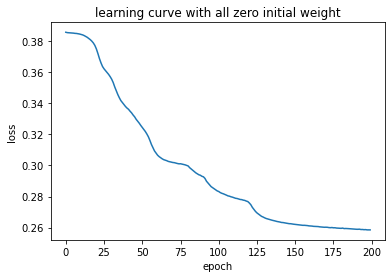

In [204]:
plot_learning_curve(train_loss, EPOCHS, 'learning curve with all zero initial weight')

In [69]:
#set w1 to random number between -1 and 1
rand_w1 = (torch.rand(hidden_neurons, 784)-0.5)*2 
#set w2 to random number between -1 and 1
rand_w2 = (torch.rand(10, hidden_neurons)-0.5)*2 

model.fc1.weight = nn.Parameter(rand_w1)
model.fc2.weight = nn.Parameter(rand_w2)

opt = torch.optim.SGD(model.parameters(), lr=0.1)
criterion = torch.nn.CrossEntropyLoss()

train_loss = train_model(model, 200)

In [70]:
test_model(model)

accuracy:  0.711     error rate:  0.289


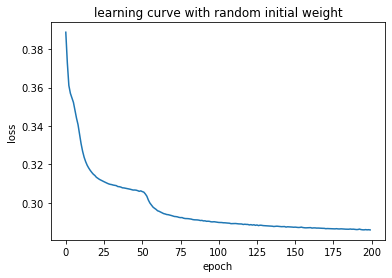

In [71]:
plot_learning_curve(train_loss, EPOCHS, 'learning curve with random initial weight')